# TOC geographic stats

What are the relative sizes of the different TOC tiers? How are they zoned?

In [1]:
import contextily
import intake
import geopandas
import matplotlib.pyplot as plt
import scipy.constants as constants

First, we load the TOC shapefile, as well as zoning data from the GeoHub:

In [2]:
cat = intake.open_catalog("../catalogs/*.yml")

In [3]:
toc_tiers = cat.toc_tiers.read()
zoning = cat.zoning.read()
zoning.crs = {'init': 'epsg:2229'}

Compute the area of the TOC tiers in acres and square miles:

In [4]:
toc_tiers = (
    toc_tiers.assign(
        acres=toc_tiers.area*constants.foot*constants.foot/constants.acre,
        sqmiles=toc_tiers.area/5280./5280.
    )
    .rename(columns={"FINALTIER": "tier"})[["tier", "acres", "sqmiles", "geometry"]]
    .sort_values(by="tier").reindex()
)

Filter the zoning data by zone classes which are eligible for developments of five or more units
(that is to say, TOC eligible):

In [5]:
toc_eligible_zoning = zoning[
    zoning.ZONE_CLASS.isin(
        [
            'C1',
            'C1.5',
            'C1(PV)',
            'C2',
            'C2(PV)'
            'C4',
            'C5',
            'CR',
            'CW',
            'RD1.5',
            'RD2',
            'RD3',
            'RD4',
            'RD5',
            'RD6',
            'R3',
            'R4',
            'R5',
            'RAS4',
            'RAS3',
        ]
    )
]

Intersect the TOC eligible zones with the TOC tiers to get all the zoning shapes
which might have a TOC development on it:

In [6]:
union = toc_eligible_zoning.buffer(0).unary_union
toc_tiers = toc_tiers.assign(
    eligible_geometry=toc_tiers.geometry.intersection(union),
)
toc_tiers = toc_tiers.assign(
    eligible_acres=geopandas.GeoSeries(toc_tiers.eligible_geometry).area*constants.foot*constants.foot/constants.acre,
    eligible_sqmiles=geopandas.GeoSeries(toc_tiers.eligible_geometry).area/5280./5280.
)
toc_tiers = toc_tiers.assign(
    eligible_fraction=toc_tiers.eligible_sqmiles/toc_tiers.sqmiles
)

Display the results:

,tier,sqmiles,eligible_sqmiles,eligible_fraction
1,1,72.790283,12.168639,0.167174
0,2,33.209209,7.650625,0.230377
2,3,56.533739,14.767714,0.261219
3,4,4.158393,1.242764,0.298857


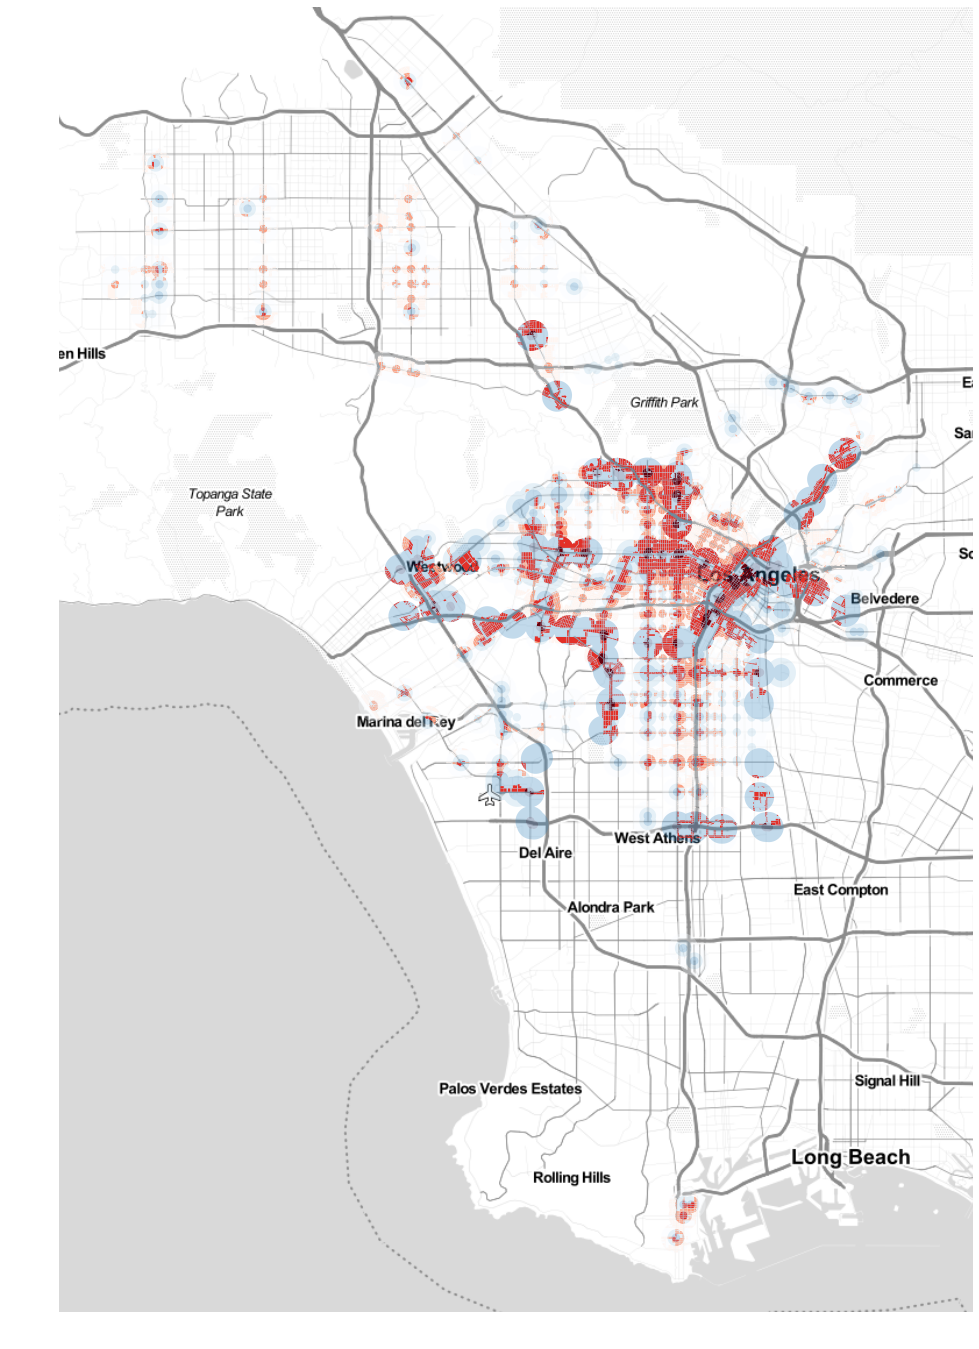

In [7]:
display(toc_tiers[["tier", "sqmiles", "eligible_sqmiles", "eligible_fraction"]])

WEB_MERCATOR = 3857
fig, ax = plt.subplots(figsize=(24,24))
toc_tiers.to_crs(epsg=WEB_MERCATOR).plot(alpha=0.3, cmap="Blues", ax=ax, column="tier")
toc_tiers.set_geometry("eligible_geometry").to_crs(epsg=WEB_MERCATOR).plot(cmap="Reds", ax=ax, column="tier")
contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)
ax.set_axis_off()